In [49]:
library(dplyr)
library(lubridate)
library(R.matlab)
library(tidyr)
library(tibble)
library(rdbnomics)
library(magrittr)
library(ggplot2)

In [50]:
gdp_values <- rdb(ids="INSEE/CNT-2010-PIB-EQB-RF/T.CNT-EQUILIBRE_PIB.SO.PIB.SO.VALEUR_ABSOLUE.FE.V.EUROS.CVS-CJO") %>%
add_column(var="gdp_values")

In [51]:
expenditures_values <-
rdb(ids="INSEE/CNT-2010-CSI/T.CNT-OPERATIONS_SECTEURS_INST.S13.E.OTE.VALEUR_ABSOLUE.FE.EUROS.CVS-CJO") %>%
add_column(var="expenditures_values")

In [52]:
debt_gdp <-
rdb(ids="INSEE/DETTE-TRIM-APU/T.DETTE_MAASTRICHT.S13.F.PROPORTION.FE.POURCENT.BRUT.SO") %>%
add_column(var="debt_gdp") %>%
mutate(value=value/100)

In [53]:
rawdata <-
bind_rows(gdp_values,expenditures_values,debt_gdp) %>%
select(period,value,var) %>%
spread(var,value) %>%
mutate(expenditures_gdp=expenditures_values/gdp_values) %>%
select(period,expenditures_gdp,debt_gdp) %>%
filter(year(period)>=1996 & year(period)<=2017) %>%
mutate(period=paste(year(period),quarter(period),sep="Q"))

colnames(rawdata)[1] <- ""

In [54]:
head(data)

ct,it,yt,expt,dt,eg
0.2853635,0.1500000,1.0000000,0.5646365,0.968000,NaN
0.3542000,0.2222784,1.1257503,0.5492719,1.024048,0
0.3987407,0.1967678,1.1301168,0.5346082,1.065824,0
0.4002874,0.1516239,1.0727561,0.5208448,1.094130,0
0.3799702,0.1286670,1.0167789,0.5081417,1.109931,0
0.3601431,0.1291815,0.9859457,0.4966211,1.114321,0


In [55]:
write.csv(data,"data.csv",row.names = F)

In [56]:
system2(
    'octave',
    args = c('--eval', '"addpath /usr/local/lib/dynare/matlab/; dynare model.mod"', '--no-window-system'),
    stdout = "stdout.txt",
    stderr = "stderr.txt",
    stdin = "",
    input = NULL,
    env = character(),
    wait = TRUE,
)
# The output of this command is written in files `stderr.txt` and `stdout.txt`.

# Dynare use the model `model.mod` and generate the files beginning with `model`.

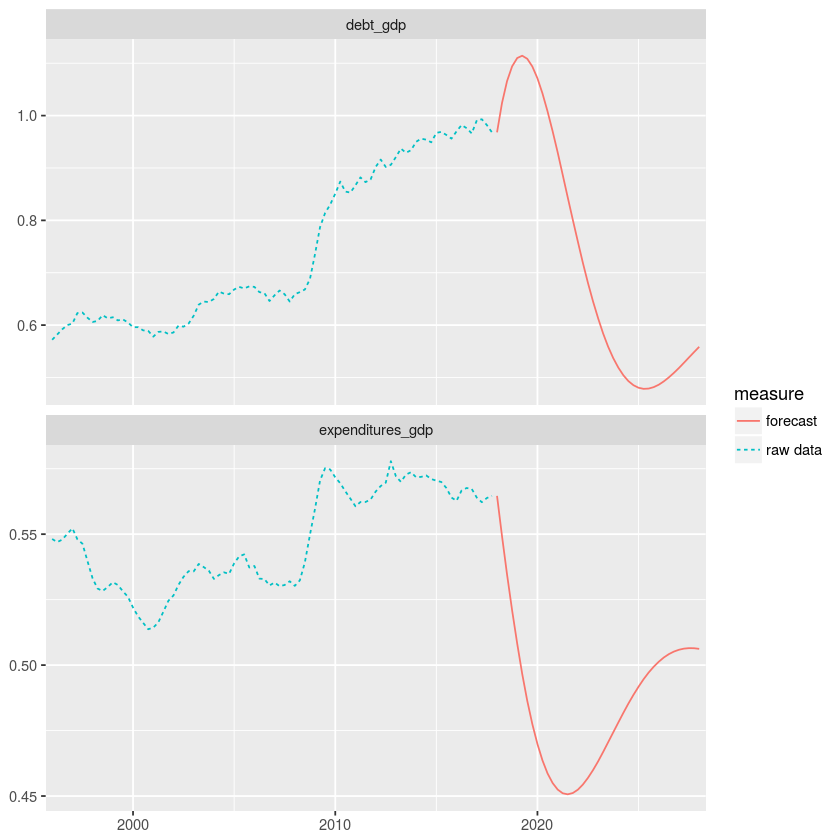

In [57]:
simuldata <- readMat("simuldata.mat",fixNames = F)
simuldatatime <- readMat("simuldatatime.mat",fixNames = F)

data <- data.frame(simuldata[[1]][1])
name <- unlist(simuldata[[1]][[3]])
colnames(data) <- name
period <- 
  as.data.frame(simuldatatime[[1]][[2]]) %>% 
  unite(period,c(V1,V2),sep="Q")

simuldata2 <-
  data %>% 
  mutate(period=period$period) %>% 
  select(period,expenditures_gdp=expt,debt_gdp=dt) %>% 
  add_column(measure="forecast")

colnames(rawdata)[1] <- "period"
rawdata %<>% add_column(measure="raw data")

df <- 
  bind_rows(simuldata2,rawdata) %>% 
  gather(var,value,-measure,-period) %>% 
  arrange(var,period) %>% 
  mutate(period=yq(period))

ggplot(df,aes(period,value,linetype=measure,colour=measure))+
  geom_line()+
  facet_wrap(~var,ncol=1,scales="free_y")+
  scale_x_date(expand = c(0.01,0.01)) +
  xlab(NULL) + ylab(NULL)